<div> 
<img src="ipt.png" width=200 height=200 />

</div>
<div style="border-style: double dashed double dashed;">
<b><center><font size="4">Weather Analysis</font></center></b>
<b><center><font size="2">Instituto Politécnico de Tomar</font></center></b>
<b><center><font size="1">Mestrado em Analítica e Inteligência Organizacional</font></center></b>
<b><center><font size="1">Arquitetura de Sistemas Analíticos</font></center></b>
</div>

**Notebook Developed by**: Soraia Pedro Tarrinha <br>
**


# Introduction


This project consisted of collecting meteorological data for five consecutive days in 11 selected cities. After collection, graphs were generated for possible behavioural analysis. 

The reference city chosen was Peniche, as it is the city located furthest along the coast of Portugal. The other cities were chosen based on their altitude and distance from the coast.
In order to better visualise the location of the cities, they will be represented on a map.

# Project structure (portfolio version)


(academic version) In addition to this library, you need to install a package that was created for the purposes of the project. The name of the package is weathermeteo.
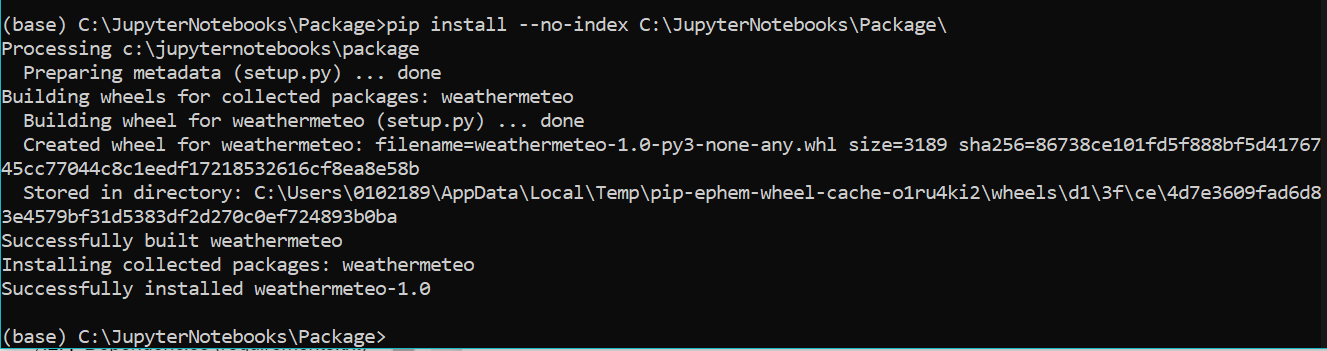

Original academic setup (kept for reference). The portfolio version does **not** require installing a local package from a Windows path.

```bash
pip install --no-index C:\JupyterNotebooks\Package\
```


The pipeline generates structured outputs into the `data/` folder (historical runs + a `latest` snapshot). This notebook loads those outputs and reproduces the analysis.


# Requirements


In the portfolio version, use:

```bash
pip install -r requirements.txt
```


# Cities represented on the map


The map below shows the selected cities used in this project.


In [1]:
import pandas as pd
import folium
import os

# Portfolio version: the pipeline writes a snapshot to data/latest_weather.csv
latest_path = os.path.join("data", "latest_weather.csv")
if not os.path.exists(latest_path):
    raise FileNotFoundError(
        "data/latest_weather.csv not found. Run the pipeline first.\n"
        "Example (Windows):\n"
        "conda run -n weather python -m scripts.run_pipeline --ref-city \"Peniche\" "
        "--cities \"Tomar\" \"Coimbra\" \"Braga\" --out-dir data\\runs"
    )

df_latest = pd.read_csv(latest_path)

# Build a simple map using city coordinates
coords = df_latest[["city", "lat", "lon"]].dropna().drop_duplicates()

portugal_map = folium.Map(location=[39.5, -8.0], zoom_start=6)

for _, row in coords.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup=row["city"]
    ).add_to(portugal_map)

portugal_map


<class 'ModuleNotFoundError'>: No module named 'folium'

After the original submission, it was noticed that the map returned Beja (Tunisia) instead of Beja (Portugal), likely due to name ambiguity in the API. Due to deadline constraints, this was not corrected in the academic version. Other locations were returned correctly.


# Data collection via API


In [11]:
import pandas as pd

ref_city = "Peniche"
ListOfCities = ["Tomar","Coimbra","Braga","Castelo Branco","Beja","Sabugal","Lisboa","Viseu","Aljustrel","Leiria"]
ListOfCitiesToCompare = ["Castelo Branco","Viseu","Sabugal","Lisboa","Braga","Peniche"]
CityTemperature = "Tomar"

# Time window used for "one day" plots.
# After loading data, you can adjust these based on available timestamps.
Timestamp1 = None
Timestamp2 = None


To generate the meteorological dataset, run the pipeline (outside the notebook). The configuration variables are defined above.


## Data generation (run outside the notebook)

This notebook assumes you already ran the pipeline to generate historical runs under `data/runs/`:

```bash
conda run -n weather python -m scripts.run_pipeline --ref-city "Peniche" --cities "Tomar" "Coimbra" "Braga" "Castelo Branco" "Beja" "Sabugal" "Lisboa" "Viseu" "Aljustrel" "Leiria" --out-dir data\runs
```

Each run creates a timestamped CSV/JSON file and updates `data/latest_weather.csv`.


In the academic version, multiple helper functions handled extraction, transformation, and saving into a JSON file. In this portfolio version, the same concept is implemented as a small pipeline and the notebook loads the generated outputs.


In [ ]:
def getWeatherData(ref_city,ListOfCities,key,distances,url_api,filename):
    cont_refcity=getWeatherrefCity(ref_city,key,url_api)
    rows_list=prepare(cont_refcity,ref_city,distances)
    for city in ListOfCities:
        content=getWeatherCitydata(city,key,url_api)
        rows_list=prepare(content,city,distances)
    savetoJson(rows_list,filename)
    return rows_list

To collect data hourly over 5 consecutive days, the original project used a Python script triggered via a Windows Task Scheduler job. The portfolio pipeline supports the same workflow by producing timestamped runs under `data/runs/`.


<div> 
<img src="taskscheduler.png" />
</div>

# JSON file


After data collection, a JSON/CSV dataset is generated containing the fields required for the charts below.


<div> 
<img src="Json.png" />
</div>

# Loading the data


To load the dataset, the pipeline outputs are read and consolidated into a dataframe for analysis.


In [6]:
import pandas as pd
import glob
import os

# Load all historical runs (each run corresponds to one collection timestamp)
run_files = sorted(glob.glob(os.path.join("data", "runs", "*_weather.csv")))
if not run_files:
    raise FileNotFoundError("No run files found in data/runs/. Run the pipeline first.")

dfs = []
for f in run_files:
    # filename format: YYYY-MM-DD_HH-MM-SS_weather.csv
    base = os.path.basename(f).replace("_weather.csv", "")
    date_part, time_part = base.split("_")
    y, m, d = date_part.split("-")
    hh, mm, ss = time_part.split("-")
    timestamp = f"{d}-{m}-{y} {hh}:{mm}:{ss}"  # keeps the original notebook format

    tmp = pd.read_csv(f)
    tmp["Timestamp"] = timestamp
    dfs.append(tmp)

dataframe = pd.concat(dfs, ignore_index=True)

# Normalize column names to keep the original notebook's conventions
dataframe = dataframe.rename(columns={
    "city": "City",
    "temp_c": "temp",
    "weather_desc": "description",
    "distance_to_ref_km": "Distance",
})

# Convert Timestamp to datetime for filtering/plotting
dataframe["Timestamp_dt"] = pd.to_datetime(dataframe["Timestamp"], format="%d-%m-%Y %H:%M:%S", errors="coerce")

dataframe.head()


# Data analysis


## Temperature for one city in a day


In [ ]:

import matplotlib.pyplot as plt

def _ensure_time_window(df, start, end):
    # If start/end not provided, choose the first available day in the dataset
    if start is None or end is None:
        dt_min = df["Timestamp_dt"].min()
        if pd.isna(dt_min):
            raise ValueError("Timestamp parsing failed. Check dataframe['Timestamp_dt'].")
        day_start = dt_min.normalize()
        day_end = day_start + pd.Timedelta(days=1)
        return day_start, day_end
    return pd.to_datetime(start, dayfirst=True), pd.to_datetime(end, dayfirst=True)

def plot_for_city_in_a_day(df, city, start=None, end=None):
    start_dt, end_dt = _ensure_time_window(df, start, end)
    d = df[(df["City"]==city) & (df["Timestamp_dt"]>=start_dt) & (df["Timestamp_dt"]<end_dt)].copy()
    d = d.sort_values("Timestamp_dt")
    fig, ax = plt.subplots()
    ax.plot(d["Timestamp_dt"], d["temp"])
    ax.set_title(f"Temperature for {city} (one day)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    fig.autofmt_xdate()
    return fig

def average_temperatures_for_city(df, city):
    d = df[df["City"]==city].copy()
    d["Date"] = d["Timestamp_dt"].dt.date
    g = d.groupby("Date")["temp"].mean().reset_index()
    fig, ax = plt.subplots()
    ax.bar(g["Date"].astype(str), g["temp"])
    ax.set_title(f"Average temperature for {city} (per day)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Avg temperature (°C)")
    ax.tick_params(axis="x", rotation=45)
    return fig

def evolution_temperature_5days(df, city):
    d = df[df["City"]==city].copy().sort_values("Timestamp_dt")
    fig, ax = plt.subplots()
    ax.plot(d["Timestamp_dt"], d["temp"])
    ax.set_title(f"Temperature evolution for {city} (all collected runs)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Temperature (°C)")
    fig.autofmt_xdate()
    return fig

def evolution_temperature_six_cities_one_day(df, cities, start=None, end=None):
    start_dt, end_dt = _ensure_time_window(df, start, end)
    fig, ax = plt.subplots()
    for city in cities:
        d = df[(df["City"]==city) & (df["Timestamp_dt"]>=start_dt) & (df["Timestamp_dt"]<end_dt)].copy().sort_values("Timestamp_dt")
        ax.plot(d["Timestamp_dt"], d["temp"], label=city)
    ax.set_title("Temperature evolution (selected cities, one day)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    fig.autofmt_xdate()
    return fig

def correlation_max_temp(df, cities):
    d = df[df["City"].isin(cities)].copy()
    d["Date"] = d["Timestamp_dt"].dt.date
    pivot = d.groupby(["City","Date"])["temp"].max().unstack("City")
    corr = pivot.corr()
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    ax.set_title("Correlation of max temperatures")
    fig.colorbar(im, ax=ax)
    return fig

def correlation_min_temp(df, cities):
    d = df[df["City"].isin(cities)].copy()
    d["Date"] = d["Timestamp_dt"].dt.date
    pivot = d.groupby(["City","Date"])["temp"].min().unstack("City")
    corr = pivot.corr()
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    ax.set_title("Correlation of min temperatures")
    fig.colorbar(im, ax=ax)
    return fig

def evolution_humidity_six_cities_one_day(df, cities, start=None, end=None):
    start_dt, end_dt = _ensure_time_window(df, start, end)
    fig, ax = plt.subplots()
    for city in cities:
        d = df[(df["City"]==city) & (df["Timestamp_dt"]>=start_dt) & (df["Timestamp_dt"]<end_dt)].copy().sort_values("Timestamp_dt")
        ax.plot(d["Timestamp_dt"], d["humidity"], label=city)
    ax.set_title("Humidity evolution (selected cities, one day)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Humidity (%)")
    ax.legend()
    fig.autofmt_xdate()
    return fig

def correlation_humidity_max_min(df, cities):
    d = df[df["City"].isin(cities)].copy()
    d["Date"] = d["Timestamp_dt"].dt.date
    max_pivot = d.groupby(["City","Date"])["humidity"].max().unstack("City")
    min_pivot = d.groupby(["City","Date"])["humidity"].min().unstack("City")

    corr_max = max_pivot.corr()
    corr_min = min_pivot.corr()

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    im1 = ax[0].imshow(corr_max.values)
    ax[0].set_title("Humidity max correlation")
    ax[0].set_xticks(range(len(corr_max.columns)))
    ax[0].set_yticks(range(len(corr_max.index)))
    ax[0].set_xticklabels(corr_max.columns, rotation=90)
    ax[0].set_yticklabels(corr_max.index)
    fig.colorbar(im1, ax=ax[0])

    im2 = ax[1].imshow(corr_min.values)
    ax[1].set_title("Humidity min correlation")
    ax[1].set_xticks(range(len(corr_min.columns)))
    ax[1].set_yticks(range(len(corr_min.index)))
    ax[1].set_xticklabels(corr_min.columns, rotation=90)
    ax[1].set_yticklabels(corr_min.index)
    fig.colorbar(im2, ax=ax[1])

    fig.tight_layout()
    return fig


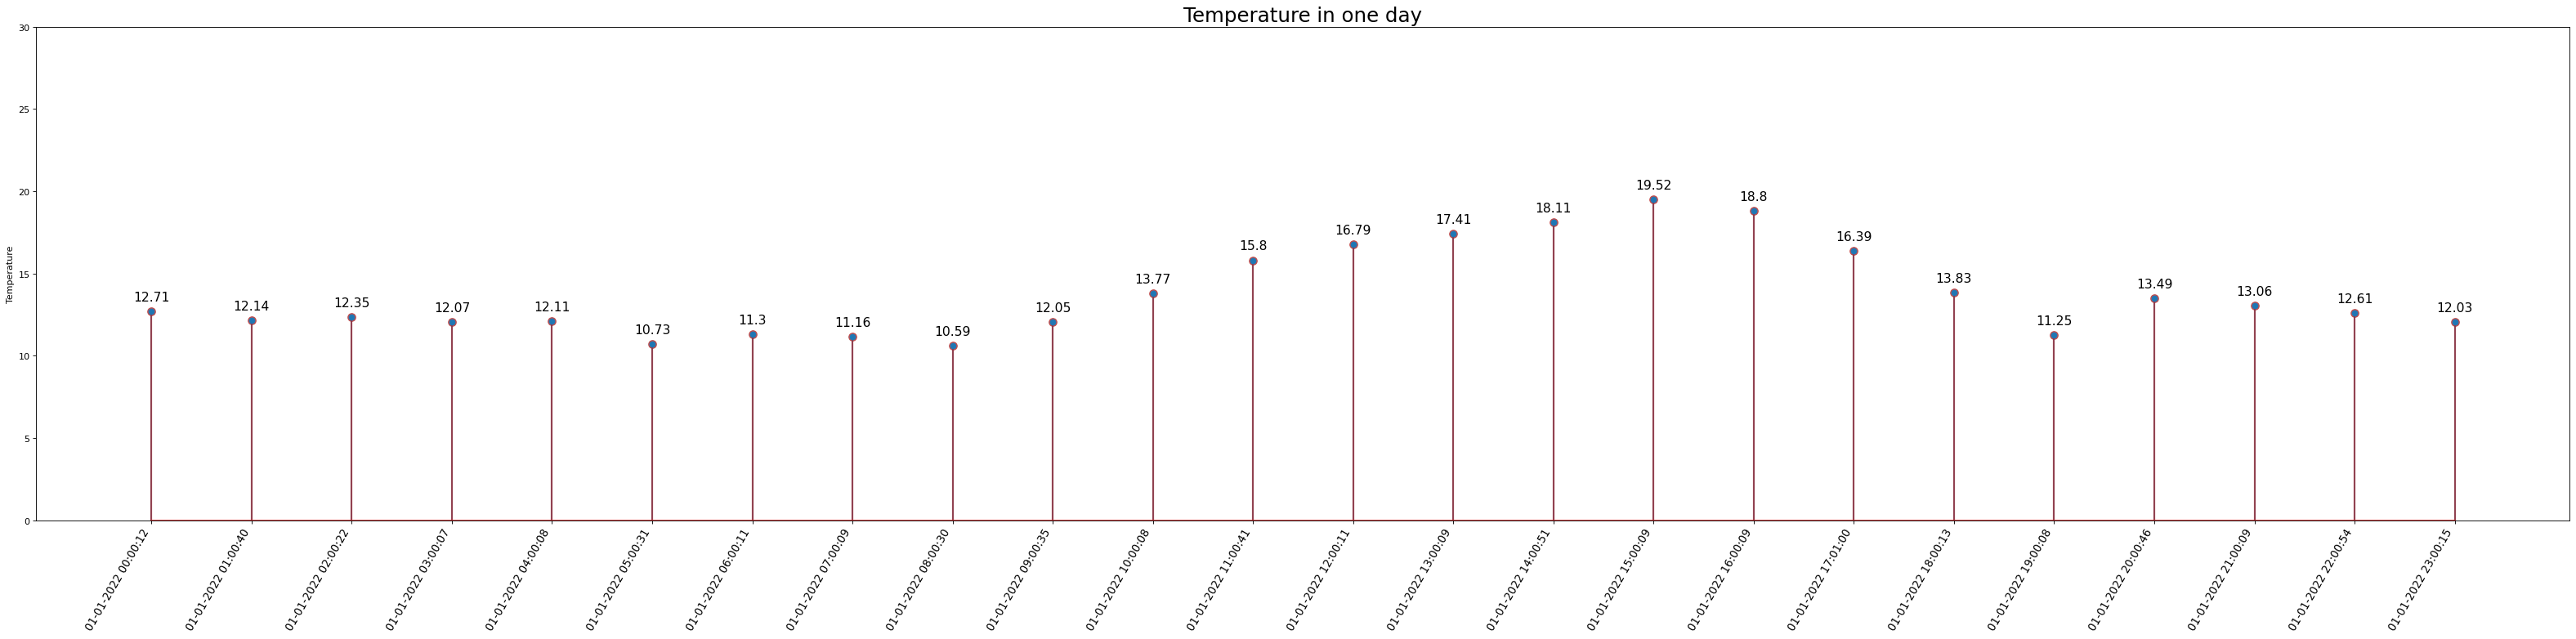

In [7]:
fig = plot_for_city_in_a_day(dataframe, CityTemperature, Timestamp1, Timestamp2)
plt.show()


From this chart, the highest temperatures occur roughly between 14:00 and 16:00, while the lowest temperatures are mostly after sunset and during the early morning.


## Average temperature for one city over multiple days


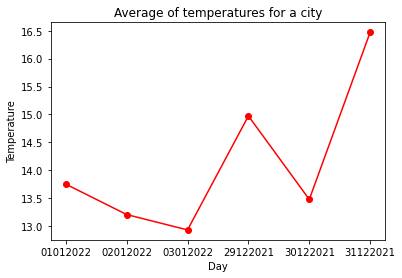

In [8]:
fig = average_temperatures_for_city(dataframe, CityTemperature)
plt.show()


In this dataset, the warmest days were December 29 and December 31, while the coldest days were January 2 and January 3.


## Temperature evolution for one city over multiple days


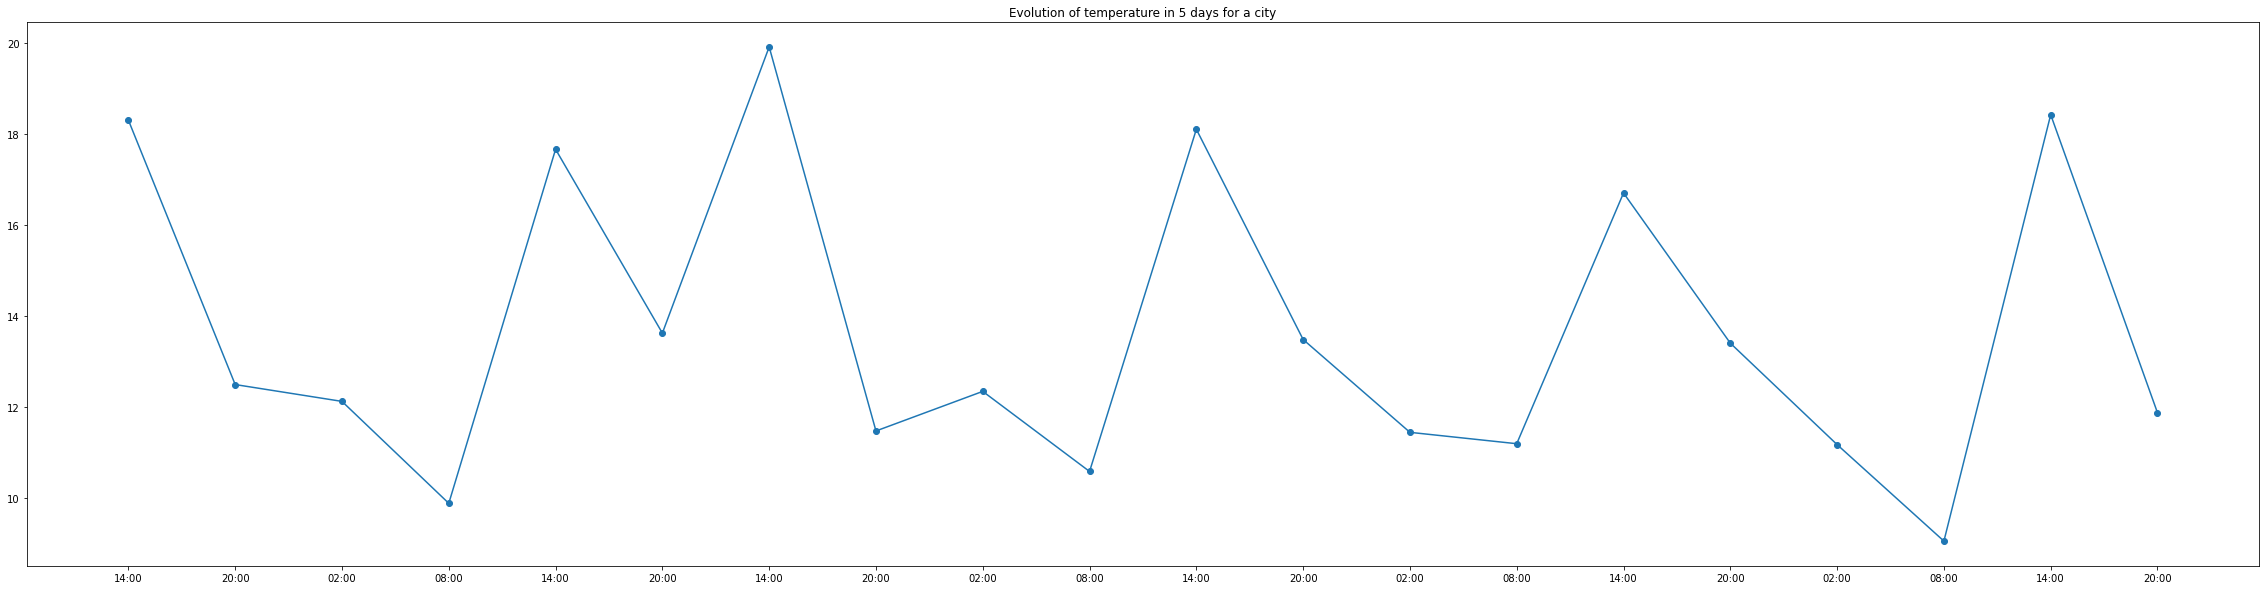

In [9]:
fig = evolution_temperature_5days(dataframe, CityTemperature)
plt.show()


From this chart, we can observe that the highest temperature occurred on the second day, while the lowest temperature was recorded on the last day.


## Temperature evolution in 6 cities (one day)


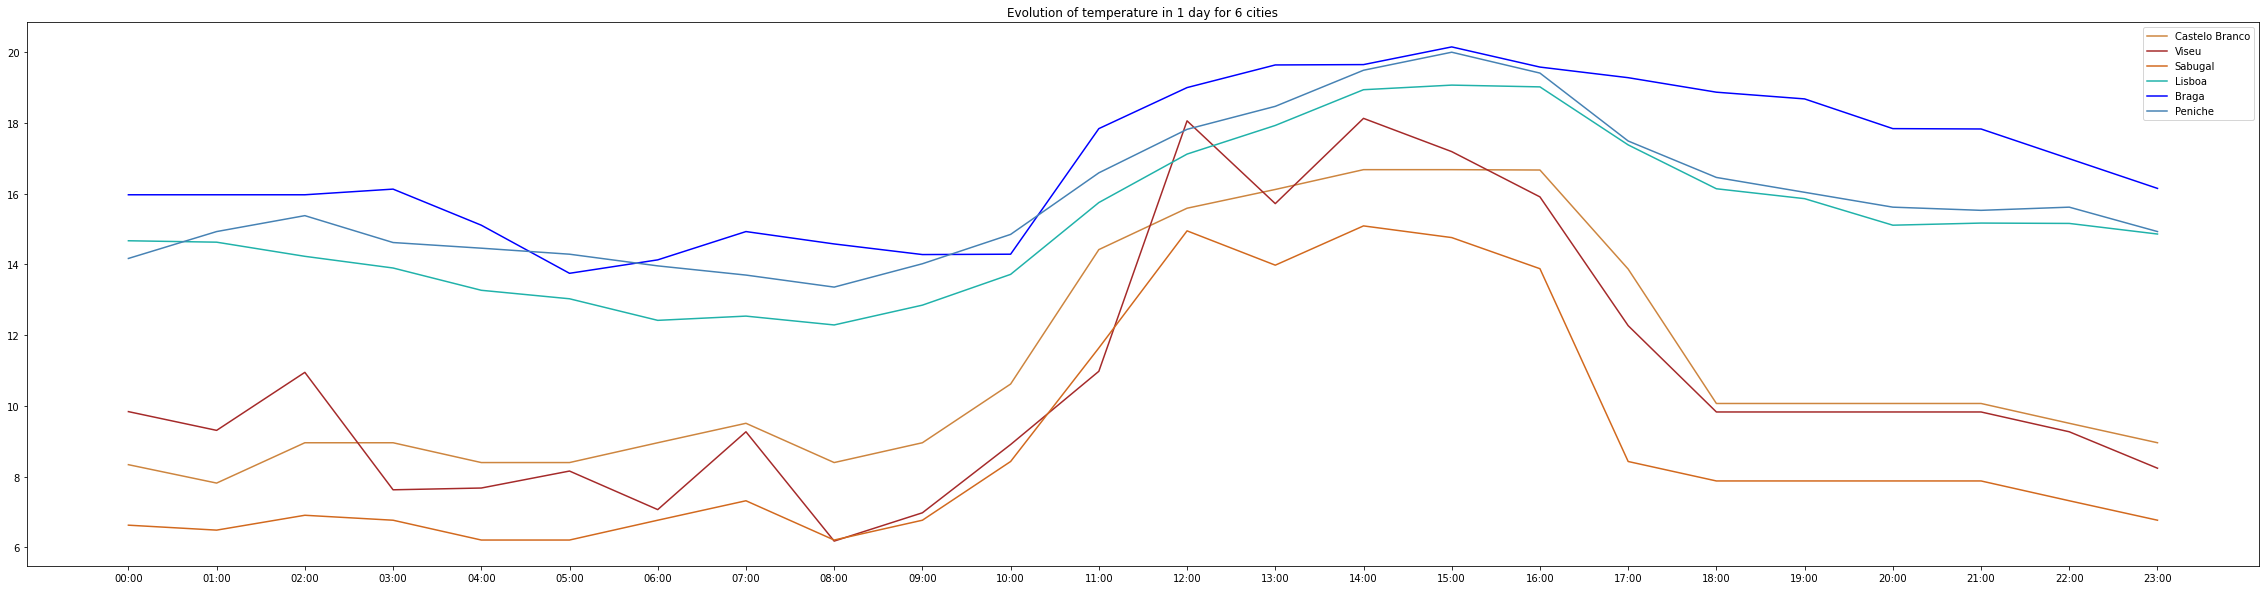

In [12]:
fig = evolution_temperature_six_cities_one_day(dataframe, ListOfCitiesToCompare, Timestamp1, Timestamp2)
plt.show()


From this chart, we can see that the highest temperatures were recorded in cities closer to the coastline. These coastal cities also show a smaller gap between minimum and maximum temperatures, which is consistent with the moderating effect of the sea.


## Correlation of maximum temperatures


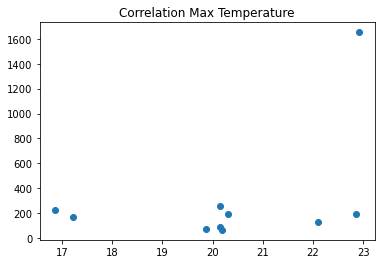

In [13]:
fig = correlation_max_temp(dataframe, [ref_city] + ListOfCities)
plt.show()


The correlation suggests that a subset of cities had very similar maximum temperatures, despite having different distances from the reference city.


## Correlation of minimum temperatures


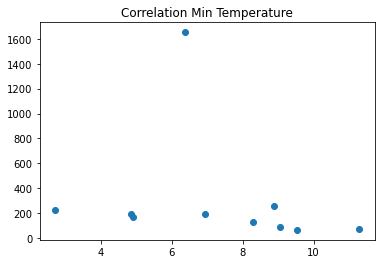

In [14]:
fig = correlation_min_temp(dataframe, [ref_city] + ListOfCities)
plt.show()


This chart shows that cities closer to the sea tend to have higher minimum temperatures, while inland cities tend to have lower minimum temperatures.


## Humidity evolution in 6 cities (one day)


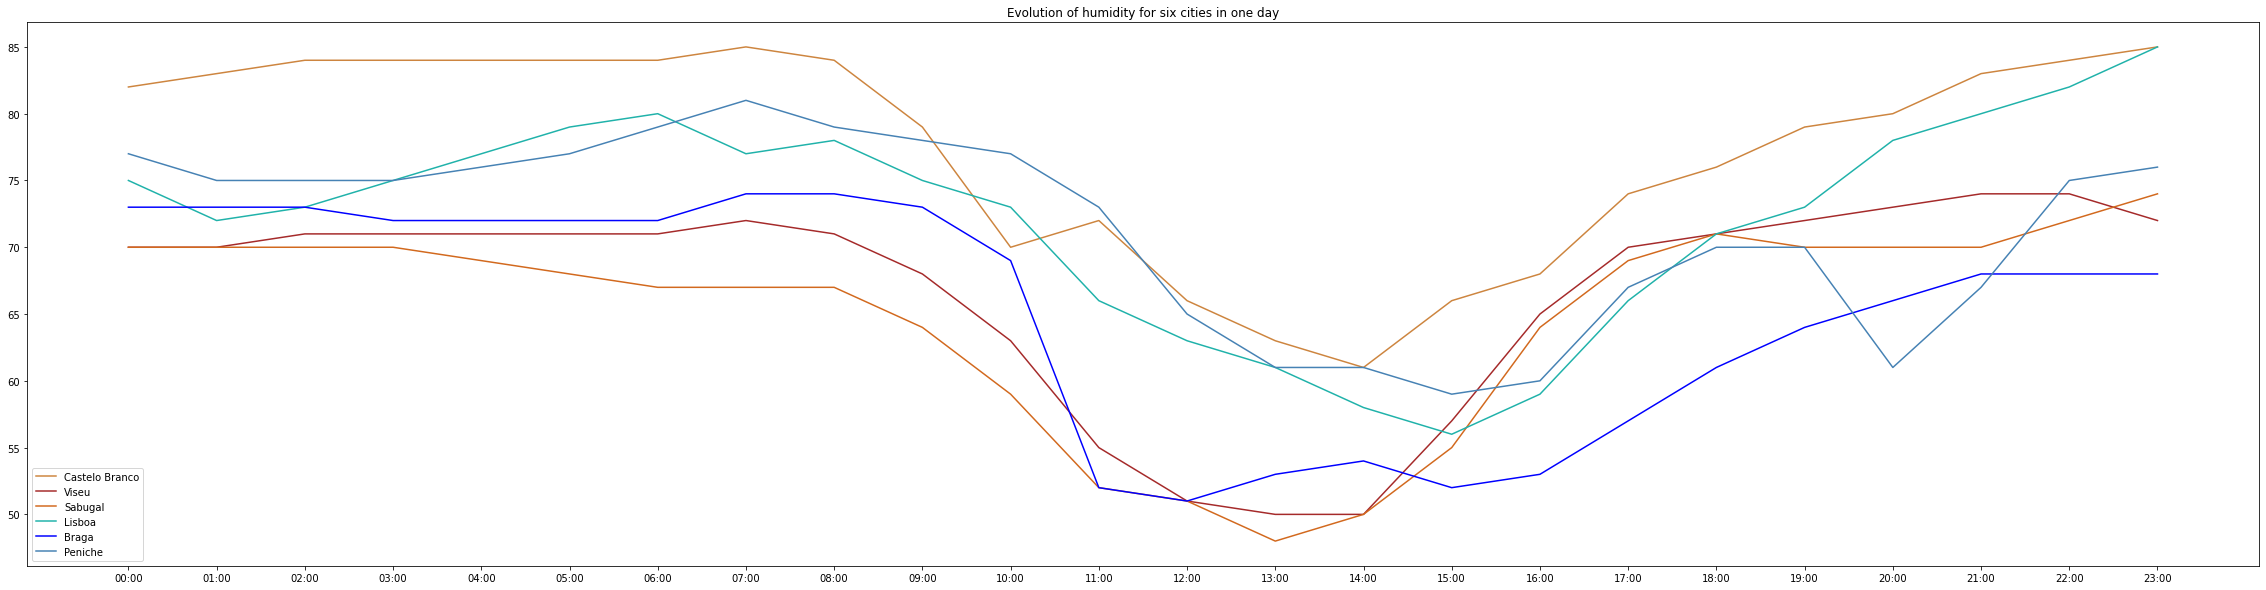

In [15]:
fig = evolution_humidity_six_cities_one_day(dataframe, ListOfCitiesToCompare, Timestamp1, Timestamp2)
plt.show()


For humidity, no major differences were observed on this day between coastal and inland cities. However, humidity tends to be lower during the warmest hours (roughly between 12:00 and 16:00).


## Correlation of maximum and minimum humidity


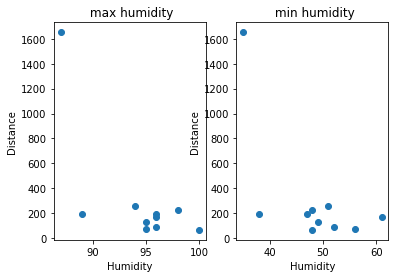

In [16]:
fig = correlation_humidity_max_min(dataframe, [ref_city] + ListOfCities)
plt.show()


For minimum vs. maximum humidity correlations, the overall behavior is similar in both cases. On average, the cities farther from the coast appear to have slightly lower humidity.
